In [1]:
using Distributed
addprocs(8);

In [2]:
@everywhere using PulseInputDDM, MAT, LinearAlgebra, Flatten

In [3]:
x_joint = Vector(undef, 3);

In [4]:
ratnames = ["B068","T034","T036","T063","T030", "T035","T011","B053", "T080","T103","E021"];
dt, n, cross = 1e-2, 53, false
data_path = joinpath(abspath(joinpath(pwd(), "..")), "data/by_session")
joint_model_path = joinpath(abspath(joinpath(pwd(), "..")), "models/joint");

# Load the data and model parameters

## FOF

In [5]:
region, delay = "FOF", 6
ratnum = 1:5
rat = ratnames[ratnum]
sessions = vcat(map(rat-> filter(x->occursin(rat,x), readdir(data_path)), rat)...);
data_FOF, = load_neural_data(joinpath.(data_path, sessions), pcut=0.01, pad=20, delay=delay, dt=dt, filtSD=5,
    do_RBF=true);

In [6]:
file = joinpath(joint_model_path, "Fig2-FOF.mat")
f = string.(read(matopen(file), "f"))
ncells = collect(read(matopen(file), "ncells"))
nparams = read(matopen(file), "nparams")
xf = read(matopen(file), "ML_params")
borg = vcat(0,cumsum(ncells, dims=1))
nparams = [nparams[i] for i in [borg[i-1]+1:borg[i] for i in 2:length(borg)]]
f = [f[i] for i in [borg[i-1]+1:borg[i] for i in 2:length(borg)]];   
x_joint[1] = xf;
joint_model_FOF = neural_choiceDDM(θneural_choice(xf, f), n, cross);

In [7]:
choice_inputs = map(x-> PulseInputDDM.choiceinputs(clicks=x.clicks, binned_clicks=x.binned_clicks, 
    dt=dt, centered=false), getfield.(vcat(data_FOF...), :input_data));
choice_data_FOF = PulseInputDDM.choicedata.(choice_inputs, getfield.(vcat(data_FOF...), :choice));
choice_model_FOF = choiceDDM(θ=Flatten.reconstruct(θchoice(), x_joint[1][1:9]), n=n, cross=cross);

## PPC

In [8]:
region, delay = "PPC", 12
ratnum = 6:8
rat = ratnames[ratnum]
sessions = vcat(map(rat-> filter(x->occursin(rat,x), readdir(data_path)), rat)...);
data_PPC, = load_neural_data(joinpath.(data_path, sessions), pcut=0.01, pad=20, delay=delay, dt=dt, filtSD=5,
    do_RBF=true);

In [9]:
file = joinpath(joint_model_path, "Fig2-PPC.mat")
f = string.(read(matopen(file), "f"))
ncells = collect(read(matopen(file), "ncells"))
nparams = read(matopen(file), "nparams")
xf = read(matopen(file), "ML_params")
borg = vcat(0,cumsum(ncells, dims=1))
nparams = [nparams[i] for i in [borg[i-1]+1:borg[i] for i in 2:length(borg)]]
f = [f[i] for i in [borg[i-1]+1:borg[i] for i in 2:length(borg)]];   
x_joint[2] = xf;
joint_model_PPC = neural_choiceDDM(θneural_choice(xf, f), n, cross);

In [10]:
choice_inputs = map(x-> PulseInputDDM.choiceinputs(clicks=x.clicks, binned_clicks=x.binned_clicks, 
    dt=dt, centered=false), getfield.(vcat(data_PPC...), :input_data));
choice_data_PPC = PulseInputDDM.choicedata.(choice_inputs, getfield.(vcat(data_PPC...), :choice));
choice_model_PPC = choiceDDM(θ=Flatten.reconstruct(θchoice(), x_joint[2][1:9]), n=n, cross=cross);

## ADS

In [11]:
region, delay = "ADS", 6
ratnum = 9:11
rat = ratnames[ratnum]
save_path = ENV["HOME"]*"/Projects/briandepasquale/bdd_work/analysis/joint/paper"
sessions = vcat(map(rat-> filter(x->occursin(rat,x), readdir(data_path)), rat)...);
data_ADS, = load_neural_data(joinpath.(data_path, sessions), pcut=0.01, pad=20, delay=delay, dt=dt, filtSD=5,
    do_RBF=true);

In [12]:
file = joinpath(joint_model_path, "Fig2-ADS.mat")
f = string.(read(matopen(file), "f"))
ncells = collect(read(matopen(file), "ncells"))
nparams = read(matopen(file), "nparams")
xf = read(matopen(file), "ML_params")
borg = vcat(0,cumsum(ncells, dims=1))
nparams = [nparams[i] for i in [borg[i-1]+1:borg[i] for i in 2:length(borg)]]
f = [f[i] for i in [borg[i-1]+1:borg[i] for i in 2:length(borg)]];   
x_joint[3] = xf;
joint_model_STR = neural_choiceDDM(θneural_choice(xf, f), n, cross);

In [13]:
choice_inputs = map(x-> PulseInputDDM.choiceinputs(clicks=x.clicks, binned_clicks=x.binned_clicks, 
    dt=dt, centered=false), getfield.(vcat(data_ADS...), :input_data));
choice_data_ADS = PulseInputDDM.choicedata.(choice_inputs, getfield.(vcat(data_ADS...), :choice));
choice_model_STR = choiceDDM(θ=Flatten.reconstruct(θchoice(), x_joint[3][1:9]), n=n, cross=cross);

## Compute posteriors

In [14]:
import PulseInputDDM: posterior

In [16]:
output = posterior(choice_model_FOF, choice_data_FOF);
choice_post_FOF = map(x-> x[1] .* x[2], output);
output = posterior(joint_model_FOF, data_FOF);
output = vcat(output...);
xc_FOF = output[1][3];
joint_post_FOF = map(x-> x[1] .* x[2], output);

In [17]:
output = posterior(choice_model_PPC, choice_data_PPC);
choice_post_PPC = map(x-> x[1] .* x[2], output);
output = posterior(joint_model_PPC, data_PPC);
output = vcat(output...);
xc_PPC = output[1][3];
joint_post_PPC = map(x-> x[1] .* x[2], output);

In [18]:
output = posterior(choice_model_STR, choice_data_ADS);
choice_post_STR = map(x-> x[1] .* x[2], output);
output = posterior(joint_model_STR, data_ADS);
output = vcat(output...);
xc_STR = output[1][3];
joint_post_STR = map(x-> x[1] .* x[2], output);

## Find nice trials to look at

Want difference in std. to be large, longer-ish trial, and hopefully not just hitting the bound

In [19]:
using Statistics

In [20]:
xidxs = 1:n;

In [21]:
var_choice_PPC = map(x-> vec(mapslices(x-> x' * ((xc_PPC[xidxs] .- (x' * xc_PPC[xidxs])).^2), x[xidxs,:], dims=1)), choice_post_PPC);
var_joint_PPC = map(x-> vec(mapslices(x-> x' * ((xc_PPC[xidxs] .- (x' * xc_PPC[xidxs])).^2), x[xidxs,21:end-19], dims=1)), joint_post_PPC);

In [22]:
var_choice_STR = map(x-> vec(mapslices(x-> x' * ((xc_STR[xidxs] .- (x' * xc_STR[xidxs])).^2), x[xidxs,:], dims=1)), choice_post_STR);
var_joint_STR = map(x-> vec(mapslices(x-> x' * ((xc_STR[xidxs] .- (x' * xc_STR[xidxs])).^2), x[xidxs,21:end-19], dims=1)), joint_post_STR);

In [23]:
var_choice_FOF = map(x-> vec(mapslices(x-> x' * ((xc_FOF[xidxs] .- (x' * xc_FOF[xidxs])).^2), x[xidxs,:], dims=1)), choice_post_FOF);
var_joint_FOF = map(x-> vec(mapslices(x-> x' * ((xc_FOF[xidxs] .- (x' * xc_FOF[xidxs])).^2), x[xidxs,27:end-14], dims=1)), joint_post_FOF);

In [24]:
mean_joint_FOF = map(x-> vec(mapslices(x-> x' * xc_FOF[xidxs], x[xidxs,27:end-14], dims=1)), joint_post_FOF);

In [25]:
mean_choice_FOF = map(x-> vec(mapslices(x-> x' * xc_FOF[xidxs], x[xidxs,:], dims=1)), choice_post_FOF);

In [26]:
mvFOF = var.(mean_joint_FOF);

In [27]:
mmFOF = mean.(mean_choice_FOF);

In [28]:
mm_choice_FOF = mean.(mean_joint_FOF);

In [29]:
idxsFOF = findall((abs.(mmFOF) .< 5.5) .& (abs.(mm_choice_FOF) .< 5.5) .& 
    (mean.(var_choice_FOF) - mean.(var_joint_FOF) .> 4.5) 
    .& (length.(var_choice_FOF) .> 80));

In [30]:
mean_choice_PPC = map(x-> vec(mapslices(x-> x' * xc_PPC[xidxs], x[xidxs,:], dims=1)), choice_post_PPC);

In [31]:
mean_joint_PPC = map(x-> vec(mapslices(x-> x' * xc_PPC[xidxs], x[xidxs,27:end-14], dims=1)), joint_post_PPC);

In [32]:
mvPPC = var.(mean_joint_PPC);

In [33]:
mmPPC = mean.(mean_choice_PPC);

In [34]:
mm_choice_PPC = mean.(mean_joint_PPC);

In [35]:
idxsPPC = findall((abs.(mmPPC) .< 5.5) .& (abs.(mm_choice_PPC) .< 5.5) .& 
    (mean.(var_choice_PPC) - mean.(var_joint_PPC) .> 10.5) 
    .& (length.(var_choice_PPC) .> 70));

## Plot

In [36]:
using Colors, PyPlot

In [37]:
my_colors_FOF= map(x-> "#"*x, hex.(range(colorant"red", stop=colorant"green", length=2)));
my_colors_PPC= map(x-> "#"*x, hex.(range(colorant"#1822A0", stop=colorant"#E99C2F", length=2)));
my_colors_STR= map(x-> "#"*x, hex.(range(colorant"#A01892", stop=colorant"#E9E62F", length=2)));

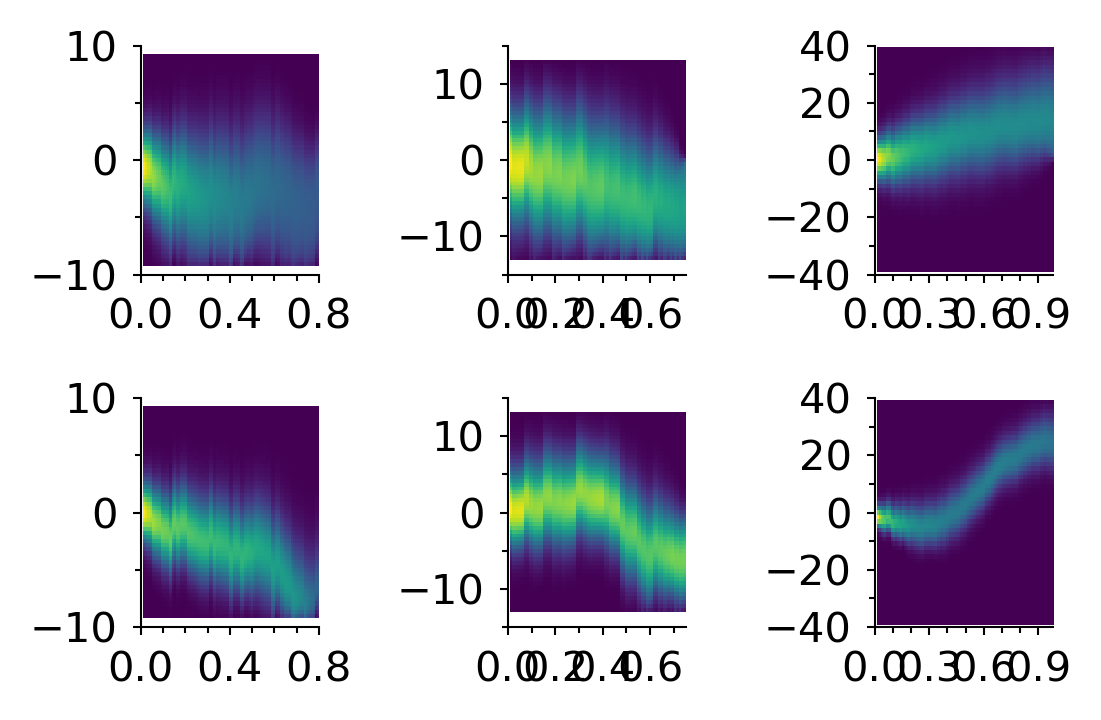

In [38]:
fig, ax = subplots(2, 3, figsize=(3.75, 2.5), dpi=300, frameon=true)

fs = 6
rc("xtick", labelsize=fs)
rc("ytick", labelsize=fs)

tri = idxsFOF[5]
T = size(joint_post_FOF[tri][:,27:end-14],2)

splt = 1
ax[splt].matshow(choice_post_FOF[tri][2:end-1,:], origin="lower", extent=[dt, dt*T, xc_FOF[2], xc_FOF[end-1]], aspect="auto")

ax[splt].xaxis.set_ticks_position("bottom")
ax[splt].xaxis.set_ticks_position("bottom")
ax[splt].spines["right"].set_visible(false)
ax[splt].spines["top"].set_visible(false)
ax[splt].spines["bottom"].set_linewidth(0.5)
ax[splt].spines["left"].set_linewidth(0.5)
ax[splt].tick_params(width=0.5, length=2)
ax[splt].set_ylim(-10,10)
ax[splt].set_yticks(range(-10, stop=10, length=3))
ax[splt].set_yticks(range(-10, stop=10, length=5), minor=true)
ax[splt].set_xticks(range(0, stop=1.2, length=4))
ax[splt].set_xticks(range(0, stop=1.1, length=12), minor=true)
ax[splt].tick_params(which="minor", width=0.5, length=1.5)
ax[splt].set_xlim(0, 0.8)


splt = 2
ax[splt].matshow(joint_post_FOF[tri][2:end-1,27:end-14], origin="lower", extent=[dt, dt*T, xc_FOF[2], xc_FOF[end-1]], aspect="auto")

ax[splt].xaxis.set_ticks_position("bottom")
ax[splt].xaxis.set_ticks_position("bottom")
ax[splt].spines["right"].set_visible(false)
ax[splt].spines["top"].set_visible(false)
ax[splt].spines["bottom"].set_linewidth(0.5)
ax[splt].spines["left"].set_linewidth(0.5)
ax[splt].tick_params(width=0.5, length=2)
ax[splt].set_ylim(-10,10)
ax[splt].set_yticks(range(-10, stop=10, length=3))
ax[splt].set_yticks(range(-10, stop=10, length=5), minor=true)
ax[splt].set_xticks(range(0, stop=1.2, length=4))
ax[splt].set_xticks(range(0, stop=1.1, length=12), minor=true)
ax[splt].tick_params(which="minor", width=0.5, length=1.5)
ax[splt].set_xlim(0, 0.8)

tri = idxsPPC[11]
T = size(joint_post_PPC[tri][:,33:end-8],2)

splt = 3
ax[splt].matshow(choice_post_PPC[tri][2:end-1,:], origin="lower", extent=[dt, dt*T, xc_PPC[2], xc_PPC[end-1]], aspect="auto")

ax[splt].xaxis.set_ticks_position("bottom")
ax[splt].xaxis.set_ticks_position("bottom")
ax[splt].spines["right"].set_visible(false)
ax[splt].spines["top"].set_visible(false)
ax[splt].spines["bottom"].set_linewidth(0.5)
ax[splt].spines["left"].set_linewidth(0.5)
ax[splt].tick_params(width=0.5, length=2)
ax[splt].set_ylim(-15,15)
ax[splt].set_yticks(range(-10, stop=10, length=3))
ax[splt].set_yticks(range(-15, stop=15, length=7), minor=true)
ax[splt].set_xticks(range(0, stop=0.8, length=5))
ax[splt].set_xticks(range(0, stop=0.8, length=9), minor=true)
ax[splt].tick_params(which="minor", width=0.5, length=1.5)
ax[splt].set_xlim(0,0.75)


splt = 4
ax[splt].matshow(joint_post_PPC[tri][2:end-1,33:end-8], origin="lower", extent=[dt, dt*T, xc_PPC[2], xc_PPC[end-1]], aspect="auto")

ax[splt].xaxis.set_ticks_position("bottom")
ax[splt].xaxis.set_ticks_position("bottom")
ax[splt].spines["right"].set_visible(false)
ax[splt].spines["top"].set_visible(false)
ax[splt].spines["bottom"].set_linewidth(0.5)
ax[splt].spines["left"].set_linewidth(0.5)
ax[splt].tick_params(width=0.5, length=2)
ax[splt].set_ylim(-15,15)
ax[splt].set_yticks(range(-10, stop=10, length=3))
ax[splt].set_yticks(range(-15, stop=15, length=7), minor=true)
ax[splt].set_xticks(range(0, stop=0.8, length=5))
ax[splt].set_xticks(range(0, stop=0.8, length=9), minor=true)
ax[splt].tick_params(which="minor", width=0.5, length=1.5)
ax[splt].set_xlim(0,0.75)

tri = 67
T = size(joint_post_STR[tri][:,27:end-14],2);

splt = 5
ax[splt].matshow(choice_post_STR[tri][2:end-1,:], origin="lower", extent=[dt, dt*T, xc_STR[2], xc_STR[end-1]], aspect="auto")

ax[splt].xaxis.set_ticks_position("bottom")
ax[splt].xaxis.set_ticks_position("bottom")
ax[splt].spines["right"].set_visible(false)
ax[splt].spines["top"].set_visible(false)
ax[splt].spines["bottom"].set_linewidth(0.5)
ax[splt].spines["left"].set_linewidth(0.5)
llim, ulim = ylim()
ax[splt].tick_params(width=0.5, length=2)
ax[splt].set_ylim(-40,40)
ax[splt].set_yticks(range(-40, stop=40, length=5))
ax[splt].set_yticks(range(-40, stop=40, length=9), minor=true)
ax[splt].set_xticks(range(0, stop=0.9, length=4))
ax[splt].set_xticks(range(0, stop=0.9, length=10), minor=true)
ax[splt].tick_params(which="minor", width=0.5, length=1.5)

splt = 6
ax[splt].matshow(joint_post_STR[tri][2:end-1,27:end-14], origin="lower", extent=[dt, dt*T, xc_STR[2], xc_STR[end-1]], aspect="auto")

ax[splt].xaxis.set_ticks_position("bottom")
ax[splt].xaxis.set_ticks_position("bottom")
ax[splt].spines["right"].set_visible(false)
ax[splt].spines["top"].set_visible(false)
ax[splt].spines["bottom"].set_linewidth(0.5)
ax[splt].spines["left"].set_linewidth(0.5)
ax[splt].tick_params(width=0.5, length=2)
ax[splt].set_ylim(-40,40)
ax[splt].set_yticks(range(-40, stop=40, length=5))
ax[splt].set_yticks(range(-40, stop=40, length=9), minor=true)
ax[splt].set_xticks(range(0, stop=0.9, length=4))
ax[splt].set_xticks(range(0, stop=0.9, length=10), minor=true)
ax[splt].tick_params(which="minor", width=0.5, length=1.5)

tight_layout()
display(gcf())
close(gcf())
#PyPlot.savefig(joinpath(abspath(joinpath(pwd(), "..")), "figs/")*"Fig5A.pdf")

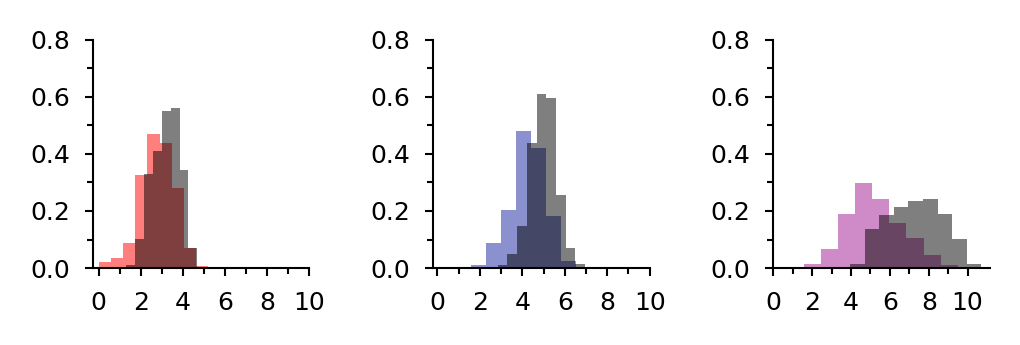

In [39]:
fig, ax = subplots(1, 3, figsize=(3.5, 1.25), dpi=300, frameon=true)

rc("xtick", labelsize=6)
rc("ytick", labelsize=6)
rc("font", family="sans-serif")

subplot(1,3,1)
hist(sqrt.(vcat(var_joint_FOF...)), alpha=0.5, label="choice and neural", color=my_colors_FOF[1]; density=true)
hist(sqrt.(vcat(var_choice_FOF...)), alpha=0.5, label="choice", color="black"; density=true)

ax = gca()
ax.xaxis.set_ticks_position("bottom")
ax.spines["right"].set_visible(false)
ax.spines["top"].set_visible(false)
ax.spines["bottom"].set_linewidth(0.5)
ax.spines["left"].set_linewidth(0.5)
ax.tick_params(width=0.5, length=2)
ax.set_ylim(0, 10)
ax.set_xticks(range(0, stop=10, length=6))
ax.set_xticks(range(0, stop=10, length=11), minor=true)
ax.tick_params(which="minor", width=0.5, length=1.5)
ax.set_ylim(0, 0.8)
ax.set_yticks(range(0, stop=0.8, length=5))
ax.set_yticks(range(0, stop=0.8, length=9), minor=true)


subplot(1,3,2)
hist(sqrt.(vcat(var_joint_PPC...)), alpha=0.5, label="choice and neural", color=my_colors_PPC[1]; density=true)
hist(sqrt.(vcat(var_choice_PPC...)), alpha=0.5, label="choice", color="black"; density=true)

ax = gca()
ax.xaxis.set_ticks_position("bottom")
ax.spines["right"].set_visible(false)
ax.spines["top"].set_visible(false)
ax.spines["bottom"].set_linewidth(0.5)
ax.spines["left"].set_linewidth(0.5)
ax.tick_params(width=0.5, length=2)
ax.set_ylim(0, 10)
ax.set_xticks(range(0, stop=10, length=6))
ax.set_xticks(range(0, stop=10, length=11), minor=true)
ax.tick_params(which="minor", width=0.5, length=1.5)
ax.set_ylim(0, 0.8)
ax.set_yticks(range(0, stop=0.8, length=5))
ax.set_yticks(range(0, stop=0.8, length=9), minor=true)

subplot(1,3,3)
hist(sqrt.(vcat(var_joint_STR...)), alpha=0.5, label="choice and neural", color=my_colors_STR[1]; density=true)
hist(sqrt.(vcat(var_choice_STR...)), alpha=0.5, label="choice", color="black"; density=true)

ax = gca()
ax.xaxis.set_ticks_position("bottom")
ax.spines["right"].set_visible(false)
ax.spines["top"].set_visible(false)
ax.spines["bottom"].set_linewidth(0.5)
ax.spines["left"].set_linewidth(0.5)
ax.tick_params(width=0.5, length=2)
ax.set_ylim(0, 10)
ax.set_xticks(range(0, stop=10, length=6))
ax.set_xticks(range(0, stop=10, length=11), minor=true)
ax.tick_params(which="minor", width=0.5, length=1.5)
ax.set_ylim(0, 0.8)
ax.set_yticks(range(0, stop=0.8, length=5))
ax.set_yticks(range(0, stop=0.8, length=9), minor=true)

tight_layout()
display(gcf())
close(gcf())
#PyPlot.savefig(joinpath(abspath(joinpath(pwd(), "..")), "figs/")*"Fig5B.pdf")

In [40]:
median(sqrt.(vcat(var_choice_FOF...))) - median(sqrt.(vcat(var_joint_FOF...)))

0.4604659776961251

In [41]:
median(sqrt.(vcat(var_choice_PPC...))) - median(sqrt.(vcat(var_joint_PPC...)))

0.7180780300219869

In [42]:
median(sqrt.(vcat(var_choice_STR...))) - median(sqrt.(vcat(var_joint_STR...)))

2.2295531730545264

## 5C 

Need to recompute the posteriors because above, when we did it, we flattened them across sessions, and lost that information

In [44]:
ncells_STR = map(x-> x[1].ncells, data_ADS);

In [45]:
ncells_FOF = map(x-> x[1].ncells, data_FOF);

### ADS

In [47]:
output = posterior(joint_model_STR, data_ADS);

xc = output[1][1][3];
joint_post = map(x-> map(x-> x[1] .* x[2], x), output);

var_joint_STR = map(x-> map(x-> vec(mapslices(x-> x' * sqrt.((xc .- (x' * xc)).^2), x[:,21:end-20], dims=1)), x), 
    joint_post);

var_joint_STR = map(x-> vcat(x...), var_joint_STR);

In [48]:
data = map(x-> x, data_ADS);

In [49]:
choice_inputs = map(data-> map(x-> PulseInputDDM.choiceinputs(clicks=x.clicks, binned_clicks=x.binned_clicks, 
    dt=dt, centered=false), getfield.(data, :input_data)), data)
choice_data = map((data, choice_inputs)-> PulseInputDDM.choicedata.(choice_inputs, getfield.(data, :choice)), data, choice_inputs);
choice_model_STR = choiceDDM(θ=Flatten.reconstruct(θchoice(), x_joint[3][1:9]), 
        n=n, cross=cross);

In [51]:
output = posterior.(Ref(choice_model_STR), choice_data);
choice_post = map(x-> map(x-> x[1] .* x[2], x), output);

In [52]:
var_choice_STR = map(x-> map(x-> vec(mapslices(x-> x' * sqrt.((xc .- (x' * xc)).^2), x, dims=1)), x), choice_post);
var_choice_STR = map(x-> vcat(x...), var_choice_STR);

### FOF

In [53]:
output = posterior(joint_model_FOF, data_FOF);

xc = output[1][1][3];
joint_post = map(x-> map(x-> x[1] .* x[2], x), output);

var_joint_FOF = map(x-> map(x-> vec(mapslices(x-> x' * sqrt.((xc .- (x' * xc)).^2), x[:,21:end-20], dims=1)), x), 
    joint_post);
var_joint_FOF = map(x-> vcat(x...), var_joint_FOF);

In [54]:
data = map(x-> x, data_FOF);

In [56]:
choice_inputs = map(data-> map(x-> PulseInputDDM.choiceinputs(clicks=x.clicks, binned_clicks=x.binned_clicks, 
    dt=dt, centered=false), getfield.(data, :input_data)), data)
choice_data = map((data, choice_inputs)-> PulseInputDDM.choicedata.(choice_inputs, getfield.(data, :choice)), data, choice_inputs);
choice_model_FOF = choiceDDM(θ=Flatten.reconstruct(θchoice(), x_joint[1][1:9]), 
        n=n, cross=cross);

In [57]:
output = posterior.(Ref(choice_model_FOF), choice_data);
choice_post = map(x-> map(x-> x[1] .* x[2], x), output);
var_choice_FOF = map(x-> map(x-> vec(mapslices(x-> x' * sqrt.((xc .- (x' * xc)).^2), x, dims=1)), x), choice_post);
var_choice_FOF = map(x-> vcat(x...), var_choice_FOF);

In [58]:
blah_STR = mean.(var_joint_STR) .- mean.(var_choice_STR);

In [59]:
blah_FOF = mean.(var_joint_FOF) .- mean.(var_choice_FOF);

In [60]:
meanSTR = map(x-> mean(blah_STR[ncells_STR .== x]), sort(unique(ncells_STR)));

In [61]:
meanFOF = map(x-> mean(blah_FOF[ncells_FOF .== x]), sort(unique(ncells_FOF)));

## Plot

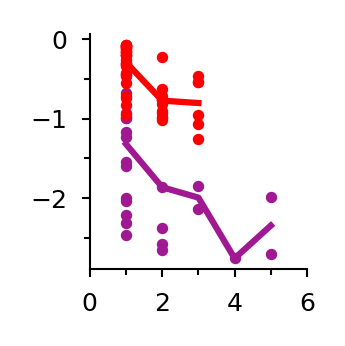

In [62]:
figure(figsize=(1.25, 1.25), dpi=300, frameon=true)

fs = 6
rc("xtick", labelsize=fs)
rc("ytick", labelsize=fs)

scatter(ncells_STR, mean.(var_joint_STR) .- mean.(var_choice_STR), 3, color=my_colors_STR[1])
scatter(ncells_FOF, mean.(var_joint_FOF) .- mean.(var_choice_FOF), 3, color=my_colors_FOF[1])
plot(unique(ncells_FOF), meanFOF, color=my_colors_FOF[1], label="FOF")
plot(sort(unique(ncells_STR)), meanSTR, color=my_colors_STR[1], label="ADS")

ax = gca()
ax.xaxis.set_ticks_position("bottom")
ax.spines["right"].set_visible(false)
ax.spines["top"].set_visible(false)
ax.spines["bottom"].set_linewidth(0.5)
ax.spines["left"].set_linewidth(0.5)
ax.tick_params(width=0.5, length=2)
ax.set_xticks(range(0, stop=6, length=4))
ax.set_xticks(range(0, stop=6, length=7), minor=true)
ax.tick_params(which="minor", width=0.5, length=1.5)
#ax.set_ylim(0, 0.5)
ax.set_yticks(range(-2, stop=0, length=3))
ax.set_yticks(range(-2.5, stop=0, length=6), minor=true)

tight_layout()
display(gcf())
close(gcf())

#PyPlot.savefig(joinpath(abspath(joinpath(pwd(), "..")), "figs/")*"Fig5C.pdf")